# Importing libraries and unzip the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 4.0 MB 42.3 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
     |████████████████████████████████| 77 kB 2.6 MB/s 
     |████████████████████████████████| 880 kB 46.0 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=e4c8bdad3d310ccf7c19bbf477e0e578d67e28043d25b1368e9f4702feb2366b
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4ceead70469cdf95938af951ad65d509d5914fc36ef11257470330c6bd20c7dc
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, util

In [ ]:
#import libraries
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
import string
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
from sklearn.linear_model import Lasso
import math
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#zip file of the dataset
#!unzip '/content/drive/MyDrive/nlp/ShortAnswerGrading_v2.0.zip'

Archive:  /content/drive/MyDrive/nlp/ShortAnswerGrading_v2.0.zip
  inflating: README                  
  inflating: papers/acl2011.final.MM.pdf  
  inflating: papers/eacl09.final.pdf  
  inflating: data/annotations/1.1.19  
  inflating: data/annotations/1.1.20  
  inflating: data/annotations/1.1.24  
  inflating: data/annotations/1.2.11  
  inflating: data/annotations/1.2.18  
  inflating: data/annotations/1.2.21  
  inflating: data/annotations/1.3.13  
  inflating: data/annotations/1.3.14  
  inflating: data/annotations/1.3.16  
  inflating: data/annotations/1.4.13  
  inflating: data/annotations/1.4.15  
  inflating: data/annotations/1.4.7  
  inflating: data/annotations/1.5.15  
  inflating: data/annotations/1.5.3  
  inflating: data/annotations/1.6.27  
  inflating: data/annotations/1.7.20  
  inflating: data/annotations/2.1.3  
  inflating: data/annotations/2.2.20  
  inflating: data/annotations/2.3.14  
  inflating: data/annotations/2.4.19  
  inflating: data/annotations/2.4.2  


# Pre-processing of the data

In [ ]:
#reading ids
file_ids = open('data/docs/files')
file_ids = file_ids.read()
ids = file_ids.split("\n")

#ids to be removed that have # in them
remove_ids = []
for id in ids:
  if('#' in id):
    remove_ids.append(id)
    
#add into a new list
ids_final = []
for id in ids:
  if id in remove_ids:
    ids_final.append(id)

In [ ]:
#reading questions
file_questions = open('data/raw/questions')
file_questions = file_questions.read()

question_list = file_questions.split("\n")
question_list = question_list[:-1]

question_ids = []
questions = []
for question in question_list:
  questions_all = question.split(" ",1)
  question_ids.append(questions_all[0]) 
  questions.append(questions_all[1])
print("Length of questions:",len(questions))


Length of questions: 87


In [ ]:
#reading answers
file_answers = open('data/raw/answers')
file_answers = file_answers.read()

answer_list = file_answers.split("\n")
answer_list = answer_list[:-1]

ids = []
correct_answers = []
for answer in answer_list:
  answers_all = answer.split(" ",1)
  ids.append(answers_all[0]) 
  correct_answers.append(answers_all[1])
print("Number of ids:",len(ids))
print("Number of correct answers:",len(correct_answers))


Number of ids: 87
Number of correct answers: 87


In [ ]:
list_questions = list(zip(ids,questions,correct_answers))
data_questions = pd.DataFrame(list_questions, columns = ['id', 'questions', 'correct_answers'])
data_questions.head()
print("Number of questions:",data_questions['id'].count())


Number of questions: 87


In [ ]:
#student answers 
all_ids = []
student_answers = []
for number in question_ids:
  #print(number)
  student_files_all = open('data/raw/' + number,encoding = "ISO-8859-1")
  #print(student_files_all)
  student_files = student_files_all.read()
  student_list = student_files.split("\n")
  student_list = student_list[:-1]


  for student_answer in student_list:
    student_all = student_answer.split(" ",1)
    all_ids.append(student_all[0])
    student_answers.append(student_all[1])
print("Number of all ids:",len(all_ids))
print("Number of student answers:",len(student_answers))

Number of all ids: 2442
Number of student answers: 2442


In [ ]:
#score1, score2, amd average scores 
all_scores_me = []
all_scores_other = []
all_scores_ave = []
for number in question_ids:
  scores_all_me = open('data/scores/'+number+'/me',encoding = "ISO-8859-1")
  scores_all_other = open('data/scores/'+number+'/other',encoding = "ISO-8859-1")
  scores_all_ave = open('data/scores/'+number+'/ave',encoding = "ISO-8859-1")
  score_files_me = scores_all_me.read()
  score_files_other = scores_all_other.read()
  score_files_ave = scores_all_ave.read()
  scores_list_me = score_files_me.split("\n")
  scores_list_me = score_files_me.split("\n")
  scores_list_other = score_files_other.split("\n")
  scores_list_ave = score_files_ave.split("\n")
  scores_list_me = scores_list_me[:-1]
  scores_list_other = scores_list_other[:-1]
  scores_list_ave = scores_list_ave[:-1]

  for ele in scores_list_me:
    all_scores_me.append(ele)
  for ele in scores_list_other:
    all_scores_other.append(ele)
  for ele in scores_list_ave:
    all_scores_ave.append(ele)

print("Total number of scores:")
print(len(all_scores_me),len(all_scores_other),len(all_scores_ave))


Total number of scores:
2442 2442 2442


In [ ]:
list_answers = list(zip(all_ids,student_answers, all_scores_me, all_scores_other, all_scores_ave))
data_answers = pd.DataFrame(list_answers, columns = ['id', 'student_answer','score1','score2','ave_score'])
data_answers.head()

,id,student_answer,score1,score2,ave_score
0,1.1,High risk problems are address in the prototyp...,4,3,3.5
1,1.1,To simulate portions of the desired final prod...,5,5,5
2,1.1,A prototype program simulates the behaviors of...,5,3,4
3,1.1,Defined in the Specification phase a prototype...,5,5,5
4,1.1,It is used to let the users have a first idea ...,3,3,3


In [ ]:
data = pd.merge(data_questions,data_answers, on = 'id')
print(len(data))
data.head()

2442


,id,questions,correct_answers,student_answer,score1,score2,ave_score
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4,3,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5,5,5
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5,3,4
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5,5,5
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3,3,3


# Visualizations

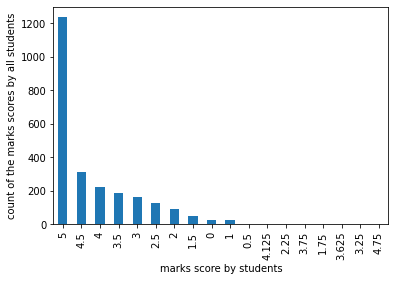

In [ ]:
#visualizations
#counts of the average scores of all the questions
p1 = data['ave_score'].value_counts().plot(kind='bar')
p1.set_xlabel('marks score by students')
p1.set_ylabel('count of the marks scores by all students')

plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 2441
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2442 non-null   object
 1   questions        2442 non-null   object
 2   correct_answers  2442 non-null   object
 3   student_answer   2442 non-null   object
 4   score1           2442 non-null   object
 5   score2           2442 non-null   object
 6   ave_score        2442 non-null   object
dtypes: object(7)
memory usage: 152.6+ KB


In [ ]:
#converting objects into floating point numbers and strings
data.score1 = data.score1.astype('float')
data.score2 = data.score2.astype('float')
data.ave_score = data.ave_score.astype('float')
data.questions = data.questions.astype('string')
data.correct_answers = data.correct_answers.astype('string')
data.student_answer = data.student_answer.astype('string')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 2441
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2442 non-null   object 
 1   questions        2442 non-null   string 
 2   correct_answers  2442 non-null   string 
 3   student_answer   2442 non-null   string 
 4   score1           2442 non-null   float64
 5   score2           2442 non-null   float64
 6   ave_score        2442 non-null   float64
dtypes: float64(3), object(1), string(3)
memory usage: 152.6+ KB


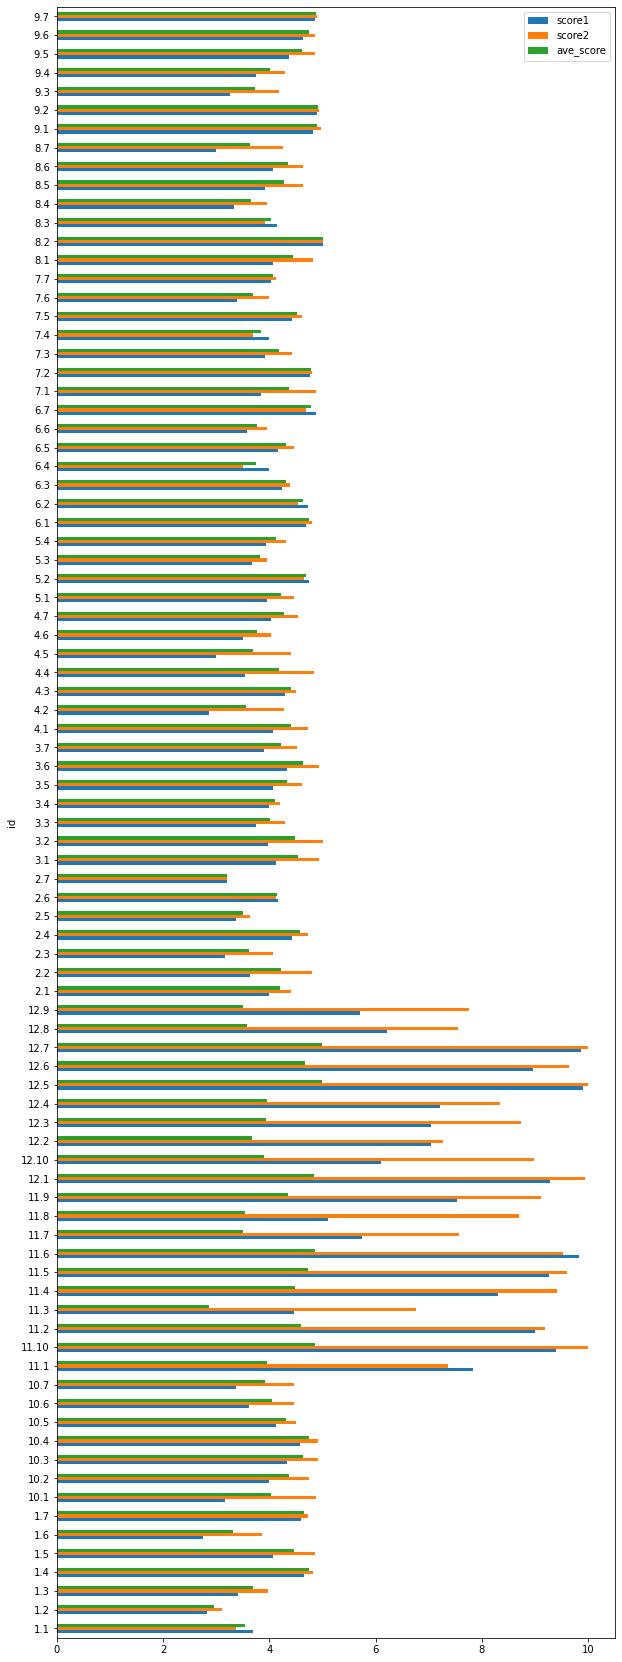

In [ ]:
#Average scores based on the question id
data_dis = data.groupby(data['id'],axis = 0).mean()
data_dis.plot.barh(figsize=(10,30))

# Pre-processing the text data

In [ ]:
data.head()

,id,questions,correct_answers,student_answer,score1,score2,ave_score
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0


In [ ]:
#preprocessing the data
def processingSentences(question, answer,print_):
  clean_sentence = []
  #replace <br> with ""
  question = question.replace("<br>","")
  answer = answer.replace("<br>", "")
  if print_:
    print(answer)
  #tokenize the question and answer
  question_tokens = word_tokenize(question)
  answer_tokens = word_tokenize(answer)
  #remove the words that appear in the question
  demoted_tokens = [word for word in answer_tokens if word not in question_tokens]
  #remove stop words
  stop_words = set(stopwords.words('english'))
  stopwords_sentence = [w for w in demoted_tokens if not w in stop_words]
  #stemming
  porter = PorterStemmer()
  stemmed_sentence = [porter.stem(word) for word in stopwords_sentence]
  #remove punctuation
  punctuations = string.punctuation
  for word in stemmed_sentence:
    if word not in punctuations:
      clean_sentence.append(word)
  return " ".join(clean_sentence) 

In [ ]:
#preprocessed example sentence
processingSentences('What is your name?',"My name is Rachana! I'm <br> a Master's student at Columbia! Email: rd2998@columbia.edu", print_=True)

My name is Rachana! I'm  a Master's student at Columbia! Email: rd2998@columbia.edu


"My rachana I 'm master 's student columbia email rd2998 columbia.edu"

In [ ]:
#preprocessing the data
def processingSentences_ (question, answer,print_):
  clean_sentence = []
  #replace <br> with ""
  answer = answer.replace("<br>", " ")
  answer = answer.lower()
  if print_:
    print(answer)
  
  answer_tokens = word_tokenize(answer)
  #remove punctuation
  punctuations = string.punctuation
  for word in answer_tokens:
    if word not in punctuations:
      clean_sentence.append(word)
  return " ".join(clean_sentence) 

# BERT similarity scores


In [ ]:
data.head()

,id,questions,correct_answers,student_answer,score1,score2,ave_score
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0


In [ ]:
#bert base model
model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
bert_similarity_score = []
for index, row in data.iterrows():
  documents = []
  question = row['questions']
  correct_answer = row['correct_answers']
  student_answer = row['student_answer']
  clean_correct_answer = processingSentences(question, correct_answer, print_= False)
  clean_student_answer = processingSentences(question, student_answer, print_= False)
  documents.append(clean_correct_answer)
  documents.append(clean_student_answer)
  print(row['id'])
  print(documents)
  text_embeddings = model.encode(documents)
  similarities = cosine_similarity(text_embeddings)
  print("Similarity score:",similarities[0][1])
  bert_similarity_score.append(similarities[0][1])

print("Bert similiaritiy scores",bert_similarity_score)
print("Length of the bert similarity scores",len(bert_similarity_score))

Streaming output truncated to the last 5000 lines.
4.5
['all except first one', 'all subsequ first one']
Similarity score: 0.8406111
4.5
['all except first one', 'two']
Similarity score: 0.6201128
4.5
['all except first one', '1 less total number']
Similarity score: 0.6776575
4.5
['all except first one', 'multi dimension array access use 1 index one dimens least']
Similarity score: 0.660674
4.6
['run-tim', '']
Similarity score: 0.50118244
4.6
['run-tim', '']
Similarity score: 0.50118244
4.6
['run-tim', '']
Similarity score: 0.50118244
4.6
['run-tim', '']
Similarity score: 0.50118244
4.6
['run-tim', 'it']
Similarity score: 0.5300744
4.6
['run-tim', 'run time']
Similarity score: 0.7172482
4.6
['run-tim', 'run-tim']
Similarity score: 1.0
4.6
['run-tim', '']
Similarity score: 0.50118244
4.6
['run-tim', '']
Similarity score: 0.50118244
4.6
['run-tim', 'thi the program compil and execut error difficult debug']
Similarity score: 0.48130268
4.6
['run-tim', 'execution-tim']
Similarity score: 0.

In [ ]:
data['bert_score'] = bert_similarity_score

In [ ]:
#data['bert_min_processed_score'] = bert_similarity_score
data.head()

,id,questions,correct_answers,student_answer,score1,score2,ave_score,bert_score
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5,0.630857
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0,0.611524
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0,0.768516
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0,0.869640
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0,0.510678


# RoBERT similarity scores

In [ ]:
model_robert = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

In [ ]:
robert_similarity_score = []
for index, row in data.iterrows():
  documents = []
  question = row['questions']
  correct_answer = row['correct_answers']
  student_answer = row['student_answer']
  clean_correct_answer = processingSentences(question, correct_answer, print_= False)
  clean_student_answer = processingSentences(question, student_answer, print_= False)
  embedding1 = model_robert.encode(clean_correct_answer)
  embedding2 = model_robert.encode(clean_student_answer)
  print(row['id'])
  similarities = util.pytorch_cos_sim(embedding1, embedding2)
  print("Similarity scores:",similarities.item())
  robert_similarity_score.append(similarities.item())

print("RoBERT similarity scores:",robert_similarity_score)

1.1
Similarity scores: 0.5554395914077759
1.1
Similarity scores: 0.2911235988140106
1.1
Similarity scores: 0.7561935186386108
1.1
Similarity scores: 0.5337948799133301
1.1
Similarity scores: 0.4622236490249634
1.1
Similarity scores: 0.03262972831726074
1.1
Similarity scores: 0.26830172538757324
1.1
Similarity scores: 0.39297372102737427
1.1
Similarity scores: 0.1403210610151291
1.1
Similarity scores: 0.7493583559989929
1.1
Similarity scores: 0.6820986270904541
1.1
Similarity scores: 0.9351913332939148
1.1
Similarity scores: 0.24267053604125977
1.1
Similarity scores: 0.41535624861717224
1.1
Similarity scores: 0.12723034620285034
1.1
Similarity scores: 0.4128605127334595
1.1
Similarity scores: 0.9471079111099243
1.1
Similarity scores: 0.3660469651222229
1.1
Similarity scores: 0.04770510271191597
1.1
Similarity scores: 0.2856665849685669
1.1
Similarity scores: 0.7493583559989929
1.1
Similarity scores: 0.9626309871673584
1.1
Similarity scores: 0.09173303842544556
1.1
Similarity scores: 0.3

In [ ]:
data['robert_score'] = robert_similarity_score
data.head()

,id,questions,correct_answers,student_answer,score1,score2,ave_score,bert_score,robert_score
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5,0.630857,0.555440
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0,0.611524,0.291124
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0,0.768516,0.756194
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0,0.869640,0.533795
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0,0.510678,0.462224


# GPT-2 similarity scores

In [ ]:
#!pip install transformers

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
from sklearn.metrics.pairwise import cosine_similarity
from numpy import array, average

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
gpt2_similarity_score = list()

for index, row in data.iterrows():
  question = row['questions']
  
  correct_answer = row['correct_answers']
  student_answer = row['student_answer']

  weights = model.transformer.wte.weight

  clean_correct_answer = processingSentences(question, correct_answer, print_= False)
  clean_student_answer = processingSentences(question, student_answer, print_= False)
  
  if len(clean_correct_answer) == 0 or len(clean_student_answer) == 0:
    clean_correct_answer = correct_answer
    clean_student_answer = student_answer

  embedding = array(weights[tokenizer.encode(clean_correct_answer, add_prefix_space=False),:].detach())
  embedding2 = array(weights[tokenizer.encode(clean_student_answer,add_prefix_space=False),:].detach())

  sbed1 = average(embedding, axis=0)
  sbed2 = average(embedding2, axis=0)

  similarity_score = cosine_similarity([sbed1], [sbed2])[0][0]

  gpt2_similarity_score.append(similarity_score)



print("GPT-2 old similarity scores:",gpt2_similarity_score)


GPT-2 old similarity scores: [0.805976, 0.8616761, 0.9438512, 0.88250744, 0.8151784, 0.66158307, 0.73887646, 0.7579859, 0.7906846, 0.9307653, 0.94054693, 0.9766587, 0.66417193, 0.7770623, 0.72748804, 0.8331086, 0.9635547, 0.75094056, 0.7301325, 0.79503804, 0.9307653, 0.9822349, 0.60826135, 0.6353249, 0.9307653, 0.7247441, 0.77310944, 0.70800054, 0.8104935, 0.82857645, 0.8039234, 0.8182208, 0.8540481, 0.7810736, 0.66141665, 0.65835834, 0.73329735, 0.62021065, 0.6477212, 0.8135127, 0.7572322, 0.6090801, 0.5326348, 0.8106539, 0.86432344, 0.7138049, 0.75143147, 0.6090801, 0.79085267, 0.65835834, 0.6573726, 0.65835834, 0.66547406, 0.7059482, 0.65835834, 0.7088735, 0.459496, 0.81261384, 0.7083887, 0.6889777, 0.7007402, 0.71026134, 0.7067168, 0.67576116, 0.76738, 0.70938575, 0.78851163, 0.66412055, 0.7220265, 0.69896, 0.6391765, 0.62448967, 0.76192474, 0.7152112, 0.7709462, 0.6835439, 0.7343111, 0.68760747, 0.69896, 0.67591786, 0.73684186, 0.6473012, 0.65251625, 0.6069697, 0.69896, 0.63552535

In [ ]:
data['gpt-2_score'] = gpt2_similarity_score
data.to_csv('/content/drive/MyDrive/nlp/data_with_scores.csv')
data.head()

,id,questions,correct_answers,student_answer,score1,score2,ave_score,bert_score,robert_score,gpt-2_score
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5,0.630857,0.555440,0.805976
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0,0.611524,0.291124,0.861676
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0,0.768516,0.756194,0.943851
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0,0.869640,0.533795,0.882507
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0,0.510678,0.462224,0.815178


# dataframe to CSV file

In [ ]:
#data.to_csv('/content/drive/MyDrive/nlp/data_with_scores_final.csv')

# Train Test split 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/nlp/data_with_scores_final.csv')

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/nlp/data_with_scores.csv')

In [ ]:
data.head()

,Unnamed: 0,id,questions,correct_answers,student_answer,score1,score2,ave_score,bert_score,robert_score,gpt-2_score
0,0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5,0.630857,0.555440,0.805976
1,1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0,0.611524,0.291124,0.861676
2,2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0,0.768516,0.756194,0.943851
3,3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0,0.869640,0.533795,0.882507
4,4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0,0.510678,0.462224,0.815178


In [ ]:
#scaling the ave_score between 0 to 1 and re-scaling it once after the prediction
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
#data['ave_scaled'] = scalar.fit_transform(data['ave_score'].to_numpy())
data['ave_scaled'] = (data['ave_score']-data['ave_score'].min())/(data['ave_score'].max()-data['ave_score'].min())
data.head()

,Unnamed: 0,id,questions,correct_answers,student_answer,score1,score2,ave_score,bert_score,robert_score,gpt-2_score,ave_scaled
0,0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5,0.630857,0.555440,0.805976,0.7
1,1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0,0.611524,0.291124,0.861676,1.0
2,2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0,0.768516,0.756194,0.943851,0.8
3,3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0,0.869640,0.533795,0.882507,1.0
4,4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0,0.510678,0.462224,0.815178,0.6


In [ ]:
from sklearn.model_selection import train_test_split
def my_train_test_split(data, score_choice):
  #feature and labels
  choices = ['bert_score', 'robert_score', 'gpt-2_score']
  X = data[choices[score_choice]]
  y = data['ave_score']
  #print(y)
  X = np.array(X).reshape((-1,1))
  y = np.array(y)
  #train test split
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
  print("X_train shape",X_train.shape)
  print("X_test shape", X_test.shape)
  print("y_train shape", y_train.shape)
  print("y_test shape", y_test.shape)
  return X_train, X_test, y_train, y_test

In [ ]:
def my_train_test_split_scaled(data, score_choice):
  #feature and labels
  choices = ['bert_score', 'robert_score', 'gpt-2_score']
  X = data[choices[score_choice]]
  #print(X)
  #scaled y
  y = data['ave_scaled']
  #print(y)
  X = np.array(X).reshape((-1,1))
  y = np.array(y)
  #train test split
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
  print("X_train shape",X_train.shape)
  print("X_test shape", X_test.shape)
  print("y_train shape", y_train.shape)
  print("y_test shape", y_test.shape)
  return X_train, X_test, y_train, y_test

In [ ]:
#testing the function
#my_train_test_split(data, 0)

# Linear Regression

In [ ]:
mse_errors = dict()

In [ ]:
def linearRegressionModel(data, score_choice):
  X_train, X_test, y_train, y_test = my_train_test_split(data, score_choice)
  model = LinearRegression()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  MSE = mean_squared_error(y_test,y_pred)
  RMSE = math.sqrt(MSE)
  return MSE, RMSE, y_pred, y_test, X_test

In [ ]:
def linearRegressionModelScaled(data, score_choice):
  X_train, X_test, y_train, y_test = my_train_test_split_scaled(data, score_choice)
  model = LinearRegression()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  MSE = mean_squared_error(y_test,y_pred)
  RMSE = math.sqrt(MSE)
  return MSE, RMSE, y_pred, y_test, X_test

# BERT Linear Regression

In [ ]:
MSE, RMSE, y_pred, y_test, _ = linearRegressionModel(data, 0)
print("Linear Regression Model using BERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using BERT scores
[3.67518602 4.04657649 3.84847433 3.55324226 4.2029482  3.6904025
 3.68251512 3.86188641 4.33523585 4.61719496] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.1369986564320846
RMSE: 1.0663013909922863


In [ ]:
MSE, RMSE, y_pred, y_test, _ = linearRegressionModelScaled(data, 0)
print("Linear Regression Model using BERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using BERT scores
[0.7350372  0.8093153  0.76969487 0.71064845 0.84058964 0.7380805
 0.73650302 0.77237728 0.86704717 0.92343899] [1.  0.9 0.3 1.  0.9 1.  1.  0.4 1.  1. ]
MSE: 0.04547994625728339
RMSE: 0.21326027819845728


# RoBERT Linear Regression

In [ ]:
MSE, RMSE, y_pred, y_test, X_test = linearRegressionModel(data,1)
print("Linear Regression Model using RoBERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)



X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using RoBERT scores
[3.85801352 3.99472869 3.89503457 3.60749476 4.48654093 4.24831437
 3.30764778 3.79594693 4.46899734 4.66081778] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.0866674071723983
RMSE: 1.0424334065888325


In [ ]:
MSE, RMSE, y_pred, y_test, X_test = linearRegressionModelScaled(data,1)

print("Linear Regression Model using RoBERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)


X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using RoBERT scores
[0.7716027  0.79894574 0.77900691 0.72149895 0.89730819 0.84966287
 0.66152956 0.75918939 0.89379947 0.93216356] [1.  0.9 0.3 1.  0.9 1.  1.  0.4 1.  1. ]
MSE: 0.043466696286895944
RMSE: 0.20848668131776654


In [ ]:
# plt.plot(X_test,y_pred, color='red')
#plt.scatter(X_test, y_test)


# GPT-2 Linear Regression

In [ ]:
MSE, RMSE, y_pred, y_test, _ = linearRegressionModel(data,2)


print("Linear Regression Model using GPT-2 scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using GPT-2 scores
[4.4202131  3.97803103 3.42438227 3.67091429 4.30042091 3.66025875
 2.81788303 4.1265819  4.34808541 4.59840605] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.1592308949936938
RMSE: 1.0766758541890376


In [ ]:
MSE, RMSE, y_pred, y_test, _ = linearRegressionModelScaled(data,2)
#linear_regression_errors.append((MSE, RMSE))

print("Linear Regression Model using GPT-2 scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using GPT-2 scores
[0.88404262 0.79560621 0.68487645 0.73418286 0.86008418 0.73205175
 0.56357661 0.82531638 0.86961708 0.91968121] [1.  0.9 0.3 1.  0.9 1.  1.  0.4 1.  1. ]
MSE: 0.046369235799747756
RMSE: 0.21533517083780754


In [ ]:
df = pd.DataFrame({
    "model_type": models,
    "mse": mse,
    "rmse": rmse
})
#sns.barplot(x = "model_type",y="mse", secondary_y = "rmse", palette = 'hls',data = df)

# Ridge Regression

In [ ]:
def ridgeRegressionModel(data, score_choice):
  X_train, X_test, y_train, y_test = my_train_test_split(data, score_choice)
  ridge = Ridge(alpha = 1.0)
  ridge.fit(X_train,y_train)
  y_pred = ridge.predict(X_test)
  MSE = mean_squared_error(y_test,y_pred)
  RMSE = math.sqrt(MSE)
  return MSE, RMSE, y_pred, y_test

In [ ]:
MSE, RMSE, y_pred, y_test = ridgeRegressionModel(data, 0)

print("Ridge Linear Regression Model using BERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Ridge Linear Regression Model using BERT scores
[3.68452014 4.04948254 3.85480916 3.56468701 4.20314775 3.69947326
 3.69172239 3.8679891  4.33314575 4.61022469] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.1375353220103146
RMSE: 1.0665530094703755


In [ ]:
MSE, RMSE, y_pred, y_test = ridgeRegressionModel(data, 1)
mse_errors['robert_score Ridge'] = MSE

print("Ridge Linear Regression Model roBERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Ridge Linear Regression Model roBERT scores
[3.861393   3.99681203 3.89806307 3.61324929 4.48396162 4.24799358
 3.31624503 3.79991483 4.46658435 4.65658623] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.0870931207272712
RMSE: 1.042637578800645


In [ ]:
MSE, RMSE, y_pred, y_test = ridgeRegressionModel(data,2)
mse_errors['gpt-2_score Ridge'] = MSE

print("Linear Regression Model using GPT-2 scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Linear Regression Model using GPT-2 scores
[4.4150273  3.98399094 3.44429752 3.68461543 4.29825462 3.67422847
 2.85308579 4.12879741 4.34471768 4.5887287 ] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.1587608942694598
RMSE: 1.076457567333455


# Lasso Regression

In [ ]:
def LassoRegressionModel(data, score_choice):
  X_train, X_test, y_train, y_test = my_train_test_split(data, score_choice)
  lasso = Lasso(alpha = 1.0)
  lasso.fit(X_train,y_train)
  y_pred = lasso.predict(X_test)
  MSE = mean_squared_error(y_test,y_pred)
  RMSE = math.sqrt(MSE)
  return MSE, RMSE, y_pred, y_test

In [ ]:
MSE, RMSE, y_pred, y_test = LassoRegressionModel(data, 0)
print("Lasso Linear Regression Model using BERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Lasso Linear Regression Model using BERT scores
[4.21447773 4.21447773 4.21447773 4.21447773 4.21447773 4.21447773
 4.21447773 4.21447773 4.21447773 4.21447773] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.2932983872795345
RMSE: 1.1372327762070238


In [ ]:
MSE, RMSE, y_pred, y_test = LassoRegressionModel(data,1)
print("Lasso Regression Model using RoBERT scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Lasso Regression Model using RoBERT scores
[4.21447773 4.21447773 4.21447773 4.21447773 4.21447773 4.21447773
 4.21447773 4.21447773 4.21447773 4.21447773] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.2932983872795345
RMSE: 1.1372327762070238


In [ ]:
MSE, RMSE, y_pred, y_test = LassoRegressionModel(data,2)
print("Lasso Regression Model using GPT-2 scores")
print(y_pred[0:10], y_test[0:10])
print("MSE:", MSE)
print("RMSE:", RMSE)

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
Lasso Regression Model using GPT-2 scores
[4.21447773 4.21447773 4.21447773 4.21447773 4.21447773 4.21447773
 4.21447773 4.21447773 4.21447773 4.21447773] [5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
MSE: 1.2932983872795345
RMSE: 1.1372327762070238


# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

def rfr (data, model_choice):  
  regr = RandomForestRegressor(max_depth=2,random_state=0)
  X_train, X_test, y_train, y_test = my_train_test_split(data, model_choice)
  regr.fit(X_train, y_train)
  regr.score(X_test,y_test)
  y_pred = regr.predict(X_test)
  MSE= (metrics.mean_squared_error(y_test,y_pred))
  print(MSE)
  print(y_pred[:10])
  print(y_test[:10])
  return MSE, _


ADD TO DICT

In [ ]:
from seaborn import regression
import seaborn as sns
import matplotlib.pyplot as plt

model_choice = [0,1,2]
models = ({
    0 : 'bert',
    1 : 'robert',
    2 : 'GPT-2'
})
data = pd.read_csv('/content/drive/MyDrive/nlp/data_with_scores_final.csv')
mse_errors = dict()
regressions = [' Linear', ' Ridge', ' Random Forest', ' Decision Tree']
for r_idx, regression_type in enumerate(regressions):
  for model_id, model_name in models.items():
    if r_idx == 0:
      MSE, RMSE, y_pred, y_test, _ = linearRegressionModel(data, model_id)
    elif r_idx == 1:
      MSE, RMSE, y_pred, y_test = ridgeRegressionModel(data,model_id)
    elif r_idx == 2:
      MSE, _ = rfr(data, model_choice=model_id)
    elif r_idx == 3:
      MSE, _ = dtr(data, model_id)
    
    rt = model_name + regression_type
    mse_errors[rt] = MSE

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
1.1123890056827523
[3.68100952 3.88496389 3.75963289 3.68100952 4.32585542 3.68100952
 3.68100952 3.7992066  4.36164418 4.78201484]
[5.  4.5 1.5 5.  4.5 5.  5.  2.  5.  5. ]
X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)
1.0932395965341808
[3.66631437 3.87705893 3.83919838 3.47467452 4.64118729 4.45434748
 3.45144297 3.57626254 4.59460232 4.

In [ ]:
df = pd.DataFrame(columns=["model_type", "regression", "MSE"])
for key,val in mse_errors.items():
  mt = key.split(" ", 1)[0]
  rt = key.split(" ", 1)[1]
  entry = pd.DataFrame.from_dict({
     "model_type": [mt],
     "regression":  [rt],
     "MSE": [val]
  })
  df = pd.concat([df, entry], ignore_index=True)

print(df)



   model_type     regression       MSE
0        bert         Linear  1.136999
1      robert         Linear  1.086667
2       GPT-2         Linear  1.159231
3        bert          Ridge  1.137535
4      robert          Ridge  1.087093
5       GPT-2          Ridge  1.158761
6        bert  Random Forest  1.112389
7      robert  Random Forest  1.093240
8       GPT-2  Random Forest  1.141297
9        bert  Decision Tree  1.121162
10     robert  Decision Tree  1.079454
11      GPT-2  Decision Tree  1.169073


Text(0, 0.5, 'MSE')

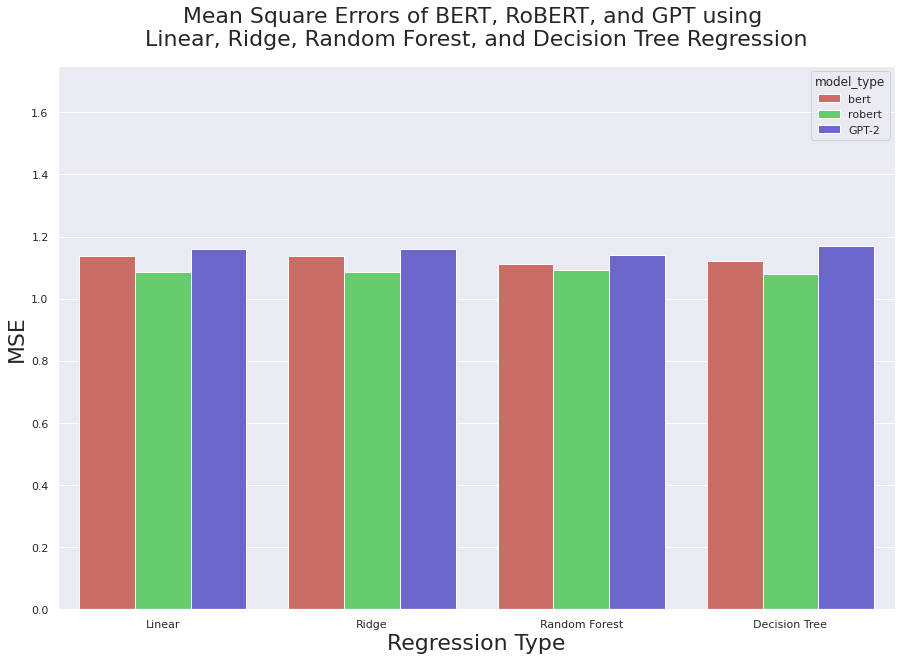

In [ ]:

sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x = 'regression', y = 'MSE', hue = 'model_type', data = df, palette="hls")
plt.title("Mean Square Errors of BERT, RoBERT, and GPT using \nLinear, Ridge, Random Forest, and Decision Tree Regression", fontsize = 22, pad=20)
plt.ylim(0, 1.75)
plt.xlabel('Regression Type', fontsize=22)
plt.ylabel('MSE', fontsize=22)

# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
def dtr(data, model_choice):
  X_train, X_test, y_train, y_test = my_train_test_split(data, model_choice)
  dt = DecisionTreeRegressor(criterion='squared_error',max_depth=3)
  dt.fit(X_train,y_train)
  y_pred = dt.predict(X_test)
  print(y_pred[:10])
  print(y_test[:10])
  dt.score(X_test,y_test)
  MSE= (metrics.mean_squared_error(y_test,y_pred))
  print(MSE)
  return MSE , _

# Testing sentences


In [ ]:
X_train, X_test, y_train, y_test = my_train_test_split_scaled(data, 2)
model = LinearRegression()
model.fit(X_train,y_train)
# print(X_test[0])
# pred = []
# pred.append(0.02)
# model.predict(np.array(pred).reshape(1,-1))

X_train shape (1953, 1)
X_test shape (489, 1)
y_train shape (1953,)
y_test shape (489,)


LinearRegression()

In [ ]:
model_robert = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

In [ ]:
def automatic_grading_sample_question_one(student_answer):
  #make a question
  question = "What is the use of stacks in data structures?"
  #give the correct answer
  correct_answer = "A stack is an abstract data type that consists of a predefined capacity. It allows adding and removing elements in a particular order."
  #give the students answer
  student_answer = student_answer
  #get the RoBERT simliarity scores
  print(correct_answer)
  print(student_answer)
  clean_correct_answer = processingSentences(question, correct_answer, print_ = False)
  clean_student_answer = processingSentences(question, student_answer, print_ = False)
  embedding1 = model_robert.encode(clean_correct_answer)
  embedding2 = model_robert.encode(clean_student_answer)
  similarities = util.pytorch_cos_sim(embedding1,embedding2)
  #print(similarities)
  sim_score = similarities.item()
  sim_score = np.array(sim_score)
  print("Your answer is similar to the correct answer approximately:",sim_score)
  #a direct method conversion
  y_pred_alt = ((sim_score/0.09)-1)*0.5
  if(y_pred_alt<0):
    y_pred_alt = 0
  if(y_pred_alt > 5):
    y_pred_alt = 5
  #get the prediction using Linear Regression
  y_pred = model.predict(sim_score.reshape(1,-1))
  if(sim_score < 0):
    y_pred = 0
  if(y_pred > 1):
    y_pred = 1
  if(y_pred < 0):
    y_pred = 0
  return y_pred * 5.0, y_pred_alt

In [ ]:
#"It allows adding and removing elements in a particular order."
answer = input()
automatic_grading_sample_question_one(answer)

In [ ]:
def automatic_grading_sample_question_two(student_answer):
  #make a question
  question = "How does BERT do classification?"
  #give the correct answer
  correct_answer = "The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after"
  #give the students answer
  student_answer = student_answer
  #get the RoBERT simliarity scores
  print(correct_answer)
  print(student_answer)
  clean_correct_answer = processingSentences(question, correct_answer, print_ = False)
  clean_student_answer = processingSentences(question, student_answer, print_ = False)
  embedding1 = model_robert.encode(clean_correct_answer)
  embedding2 = model_robert.encode(clean_student_answer)
  similarities = util.pytorch_cos_sim(embedding1,embedding2)
  #print(similarities)
  sim_score = similarities.item()
  sim_score = np.array(sim_score)
  print("Your answer is similar to the correct answer approximately:",sim_score)
  #a direct method conversion
  y_pred_alt = ((sim_score/0.09)-1)*0.5
  if(y_pred_alt<0):
    y_pred_alt = 0
  if(y_pred_alt > 5):
    y_pred_alt = 5
  #get the prediction using Linear Regression
  y_pred = model.predict(sim_score.reshape(1,-1))
  if(sim_score < 0):
    y_pred = 0
  if(y_pred > 1):
    y_pred = 1
  if(y_pred < 0):
    y_pred = 0
  return y_pred * 5.0, y_pred_alt

In [ ]:
automatic_grading_sample_question_two("BERT uses transformer endoer to process each token")

The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after
BERT uses transformer endoer to process each token
Your answer is similar to the correct answer approximately: 0.5028347969055176


(array([4.32596508]), 2.2935266494750977)